---
이전 [MAD_proto_01.ipynb]("./failed_test/MAD_proto.ipynb")에서 실패했던 내용을 바탕으로 MAD_proto_02를 수행한다.

* 수정해볼 내용은 현재 $f(x,y)=A*\sin(B*x)*\sin(C*y)$ 의 예시에서 그 범위가 크지 않음에서 문제가 생길 수 있을것 같다.
    - A의 범위, 스케일, 중앙점: [1.0, 11.0], 10, 6.0
    - B의 범위, 스케일, 중앙점: [0.5, 2.0], 1.5, 1.25
    - C의 범위, 스케일, 중앙점: [0.5, 2.0], 1.5, 1.25
    - X의 범위, 스케일, 중앙점: [$-\pi$,$\pi$], $2\pi$, 0
    - Y의 범위, 스케일, 중앙점: [$-\pi$,$\pi$], $2\pi$, 0
* 따라서 MultiScale의 Subnet을 제거하고 latent_vector만을 넣어서 다시 수행한다.
    - 이 과정에서도 기존의 MAD에서는 Latent_vector에 직접적인 Task정보를 주지않고, 여러 Task가 섞여있는 데이터를 통해 Implicit하게 정보를 embedding 한다.

* <mark class="highlight"> <strong>결론적으로 MAD_proto_02에서는 이러한 Latent_vector만을 접목하여 문제에 접근해보고자 한다.</strong></mark>

---

In [1]:
import math
import numpy as np

from tqdm import tqdm
from glob import glob

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

# 시각화
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

# Network
from net.network import LatentMLPSequential

In [2]:
# CUDA check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


# Pretraining
## Helper function

In [3]:
def compute_derivatives(model, xy_data):
    """
    Get fxx, fyy
    """
    xy_data = xy_data.to(device)
    # Ensure that xy_data has gradient information.
    xy_data.requires_grad_(True)
    
    # Get the model prediction.
    f_pred = model(xy_data)
    
    # Create a tensor of ones with the same shape as f_pred to be used for gradient computation.
    # Reshape the ones tensor to match the shape of f_pred.
    ones = torch.ones(f_pred.shape, device=device, requires_grad=False)
    
    # Compute the first derivatives.
    f_x = torch.autograd.grad(f_pred, xy_data, grad_outputs=ones, create_graph=True)[0][:, 0]
    f_y = torch.autograd.grad(f_pred, xy_data, grad_outputs=ones, create_graph=True)[0][:, 1]
    
    # Compute the second derivatives.
    f_xx = torch.autograd.grad(f_x, xy_data, grad_outputs=ones[:, 0], create_graph=True)[0][:, 0]
    f_yy = torch.autograd.grad(f_y, xy_data, grad_outputs=ones[:, 0], create_graph=True)[0][:, 1]
    
    return f_xx, f_yy

def multiscale_task_loss(model, criterion, xy_daya, f_data, B, C, alpha=0.1):
    """
    추가 도입 예정
    """
    pass


def create_dataloader(data, batch_size, shuffle=True):
    """
    get dataloader
    """
    xy_data = torch.tensor(np.stack([data.T[0], data.T[1]], axis=-1), dtype=torch.float)
    f_data = torch.tensor(data.T[2], dtype=torch.float).view(-1, 1)
    a_data = torch.tensor(data.T[3], dtype=torch.float).view(-1, 1)
    b_data = torch.tensor(data.T[4], dtype=torch.float).view(-1, 1)
    c_data = torch.tensor(data.T[5], dtype=torch.float).view(-1, 1)
    
    dataset = TensorDataset(xy_data, f_data, a_data, b_data, c_data)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return tqdm(loader, desc="Training ", leave=False)


def train_model(model, loader, epochs):
    """
    Implementation func of model training
    """
    
    for epoch in range(epochs):
        model.train()
        batch_loss = 0.0
        batch_data_loss = 0.0  # To record data loss
        batch_pde_loss = 0.0   # To record pde loss

        for batch_xy, batch_f, batch_a, batch_b, batch_c in loader:
            batch_xy = batch_xy.to(device)
            batch_f  = batch_f.to(device)
            batch_a  = batch_a.to(device)
            batch_b  = batch_b.to(device)
            batch_c  = batch_c.to(device)
            
            optimizer.zero_grad()

            # Calculate the losses
            f_pred = model(batch_xy)
            data_loss = criterion(f_pred, batch_f)
            f_xx, f_yy = compute_derivatives(model, batch_xy)
            true_pde = -(batch_b**2+batch_c**2)*f_pred
            pde_loss = criterion(f_xx + f_yy, true_pde.squeeze())

            # Combine the losses
            loss = data_loss + alpha * pde_loss

            # Backpropagate and optimize
            loss.backward()
            optimizer.step()

            # Record losses
            batch_loss += loss.item()
            batch_data_loss += data_loss.item()
            batch_pde_loss += pde_loss.item()

        avg_loss = batch_loss / len(loader)
        avg_data_loss = batch_data_loss / len(loader)
        avg_pde_loss = batch_pde_loss / len(loader)

        # Append the average losses for this epoch to the history
        loss_history.append(avg_loss)
        data_loss_history.append(avg_data_loss)
        pde_loss_history.append(avg_pde_loss)

        scheduler.step() # ReduceLROnPlateau 이면 Loss를 인자로 넣어야함

        # Print the losses every 100 epochs
        if epoch % 5 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch}/{epochs}, Total Loss: {avg_loss}, Data Loss: {avg_data_loss}, PDE Loss: {avg_pde_loss}, LR: {current_lr}')

    # 손실값 그래프를 그립니다.
    print("total loss : ",loss_history[-1])
    print("DATA  loss : ",data_loss_history[-1])
    print("PDE   loss : ",pde_loss_history[-1])
    plt.semilogy(loss_history, label="Total")
    plt.semilogy(data_loss_history, label="Data")
    plt.semilogy(pde_loss_history, label="PDE")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Epoch vs loss')
    plt.legend()
    plt.show()

def test_inference(model, test_data_path):
    with open(test_data_path, 'rb') as f:
        data = np.load(f,allow_pickle=True)
    x = data.T[0]
    y = data.T[1]
    X = data[:,:2]
    f_true = data.T[2]

    X = torch.tensor(X, dtype=torch.float)
    X = X.to(device)

    with torch.no_grad():
        f_pred = model(X).cpu().numpy().squeeze()

    loss = np.mean(np.sqrt(np.abs(np.square(f_true.reshape(-1))-np.square(f_pred.reshape(-1)))))
    print("Test MSE Loss : ", loss)

    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
    # grid
    xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]

    # f_true figure
    rbf = scipy.interpolate.Rbf(x, y, f_true)
    org = rbf(xi, yi)
    img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[0].scatter(x, y, c=f_true)
    ax[0].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)

    # f_pred figure
    rbf = scipy.interpolate.Rbf(x, y, f_pred)
    org = rbf(xi, yi)
    img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[1].scatter(x, y, c=f_pred)
    ax[1].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)
    plt.tight_layout()
    plt.show()
    
    return loss

## Implementation

## PDE Loss Coef = 0.01

* 문제
    1. Loss가 감소하지 않음, PDE, Data Loss가 모두 증가하는 것을 보면 현재 시스템 자체가 문제가 있음.
    2. 결과를 확인했을때, Mode collapse가 일어난 것을 볼 수 있음. Input의 영향이 없어짐
    3. Scale의 차이가 커짐, Input의 스케일이 11미만인데, output의 스케일이 100이상이 발생하는 경우가 있음.
* 해결방향
    1. PDE Loss Coef = 0.0001로 줄여보기
    2. In_scale 부분을 제거해보기

In [11]:
# 하이퍼 파라미터
batch_size = 50000
shuffle = True # 데이터 셔플
epochs = 1000   # 훈련 epoch
alpha= 0.01      # Total Loss = Data Loss + alpha * PDE Loss

# Data load
with open("./data/trainXYFABC.npy", 'rb') as f:
    data = np.load(f,allow_pickle=True)
f.close()

# Sample data
print(data.shape) #100000 of [x, y, f(x,y), A, B, C]

(100000, 6)


In [12]:
loader = create_dataloader(data, batch_size, shuffle)

model = LatentMLPSequential(
    in_dim=2,
    out_dim=1,
    layers=7,
    neurons=32,
    residual=True,
    in_scale= [2*np.pi,2*np.pi],
    in_center=[0, 0],
    vec_scen=2,
    vec_size=12,
)
model = model.to(device)
# loss
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10, verbose=False)
scheduler = CosineAnnealingWarmRestarts(optimizer, 500, T_mult=1, eta_min=0.0002)

# init
loss_history = []
data_loss_history = []
pde_loss_history = []
best_loss = float('inf')

#### 훈련 시작 ####
print("Train start\n")
train_model(model, loader, epochs)
print("Train end\n")

Training :   0%|          | 0/2 [00:00<?, ?it/s]

Train start



Epoch 0/1000, Total Loss: 3.4725500345230103, Data Loss: 3.4010543823242188, PDE Loss: 7.149565353989601, LR: 0.1999980280595281
Epoch 5/1000, Total Loss: 3.842223048210144, Data Loss: 3.1188689470291138, PDE Loss: 72.33540344238281, LR: 0.19992901831679488
Epoch 10/1000, Total Loss: 8.478764772415161, Data Loss: 3.1065722703933716, PDE Loss: 537.2192840576172, LR: 0.1997614893854864
Epoch 15/1000, Total Loss: 14.657747745513916, Data Loss: 3.131601572036743, PDE Loss: 1152.6146240234375, LR: 0.1994956065964319
Epoch 20/1000, Total Loss: 37.93811225891113, Data Loss: 3.449955463409424, PDE Loss: 3448.81591796875, LR: 0.1991316323438437
Epoch 25/1000, Total Loss: 128.47870445251465, Data Loss: 3.287434220314026, PDE Loss: 12519.1279296875, LR: 0.19866992582636603
Epoch 30/1000, Total Loss: 116.3209342956543, Data Loss: 3.460137367248535, PDE Loss: 11286.080078125, LR: 0.19811094269258908
Epoch 35/1000, Total Loss: 421.6466979980469, Data Loss: 3.1612396240234375, PDE Loss: 41848.5458984

KeyboardInterrupt: 

Test MSE Loss :  9.092068814946767


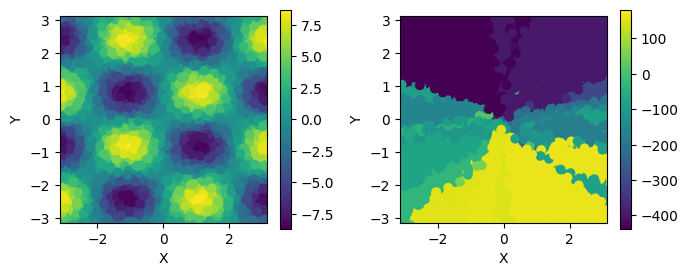

Test MSE Loss :  9.352209795424002


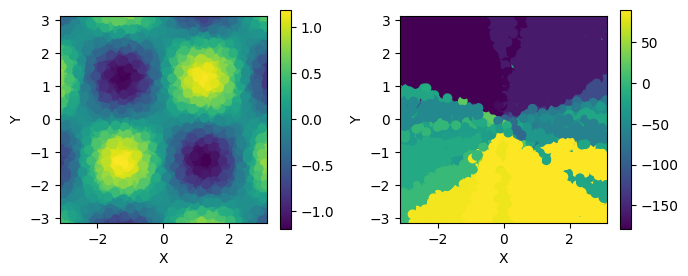

Test MSE Loss :  9.301515462179111


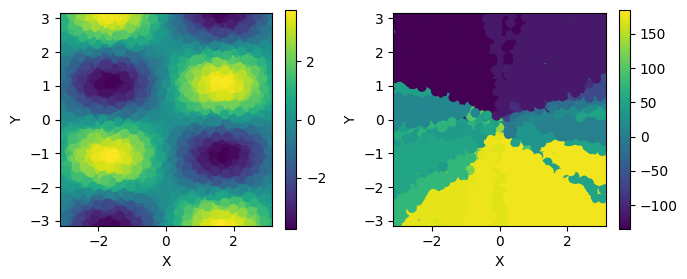

Test MSE Loss :  8.774028376379913


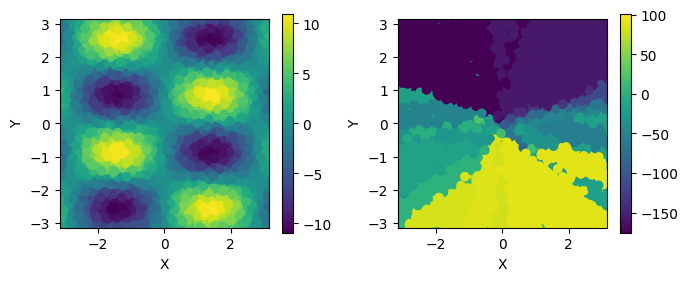

Test MSE Loss :  9.280689173830838


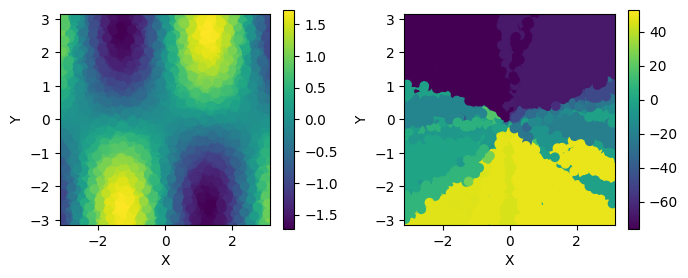

Test MSE Loss :  9.359490217060129


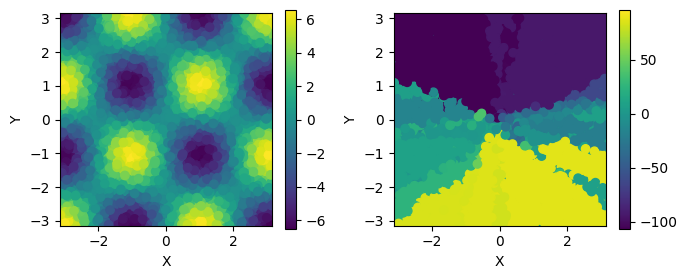

Test MSE Loss :  8.82436543239424



KeyboardInterrupt



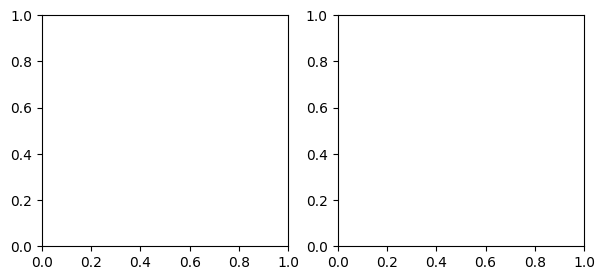

In [13]:
tasks = glob("./data/*_.npy")
for task in tasks:
    test_inference(model, task)

## PDE Loss coef = 0.00001

* 결과가 아무것도 바뀌지 않을것을 볼 수 있다.

In [16]:
# 하이퍼 파라미터
batch_size = 100000
shuffle = True # 데이터 셔플
epochs = 1000   # 훈련 epoch
alpha= 0.00001      # Total Loss = Data Loss + alpha * PDE Loss

In [17]:
loader = create_dataloader(data, batch_size, shuffle)

model = LatentMLPSequential(
    in_dim=2,
    out_dim=1,
    layers=7,
    neurons=32,
    residual=True,
    in_scale= [2*np.pi,2*np.pi],
    in_center=[0, 0],
    vec_scen=2,
    vec_size=12,
)
model = model.to(device)
# loss
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10, verbose=False)
scheduler = CosineAnnealingWarmRestarts(optimizer, 500, T_mult=1, eta_min=0.0002)

# init
loss_history = []
data_loss_history = []
pde_loss_history = []
best_loss = float('inf')

#### 훈련 시작 ####
print("Train start\n")
train_model(model, loader, epochs)
print("Train end\n")

Training :   0%|          | 0/1 [00:00<?, ?it/s]

Train start



Epoch 0/1000, Total Loss: 3.0919666290283203, Data Loss: 3.0919642448425293, PDE Loss: 0.24679511785507202, LR: 0.1999980280595281
Epoch 5/1000, Total Loss: 3.097377300262451, Data Loss: 3.089770793914795, PDE Loss: 760.653076171875, LR: 0.19992901831679488
Epoch 10/1000, Total Loss: 3.4476590156555176, Data Loss: 3.362877130508423, PDE Loss: 8478.1875, LR: 0.1997614893854864
Epoch 15/1000, Total Loss: 3.3368680477142334, Data Loss: 3.3118436336517334, PDE Loss: 2502.44482421875, LR: 0.1994956065964319
Epoch 20/1000, Total Loss: 3.2008113861083984, Data Loss: 3.18351674079895, PDE Loss: 1729.4700927734375, LR: 0.1991316323438437
Epoch 25/1000, Total Loss: 3.0581743717193604, Data Loss: 3.0468661785125732, PDE Loss: 1130.8118896484375, LR: 0.19866992582636603
Epoch 30/1000, Total Loss: 3.0855884552001953, Data Loss: 3.0746588706970215, PDE Loss: 1092.9476318359375, LR: 0.19811094269258908
Epoch 35/1000, Total Loss: 3.1135337352752686, Data Loss: 3.0443217754364014, PDE Loss: 6921.204101

KeyboardInterrupt: 

Test MSE Loss :  3.576371347624407


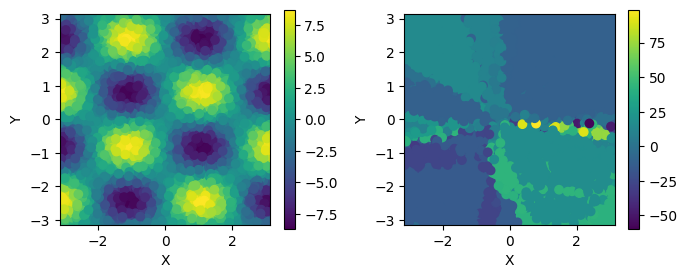

Test MSE Loss :  2.2056473568182198


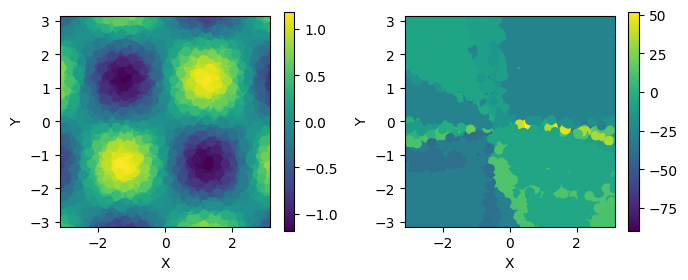

Test MSE Loss :  2.18613070841241


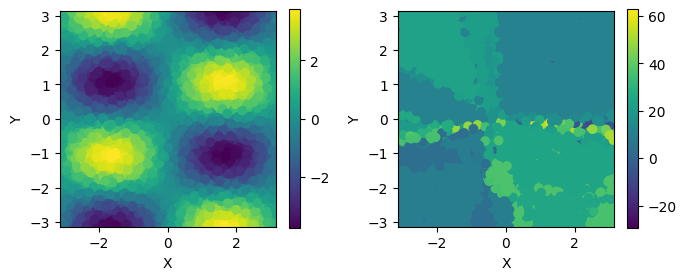

Test MSE Loss :  4.35993723150431


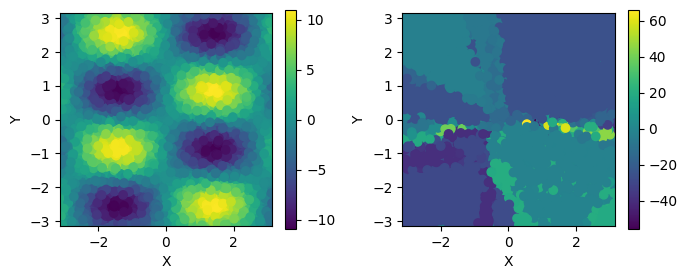

Test MSE Loss :  2.210968658852912


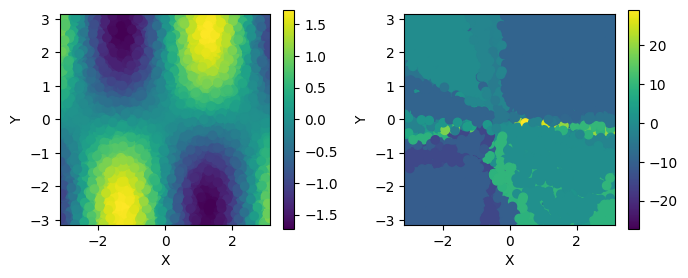

Test MSE Loss :  2.8458528148253532


KeyboardInterrupt: 

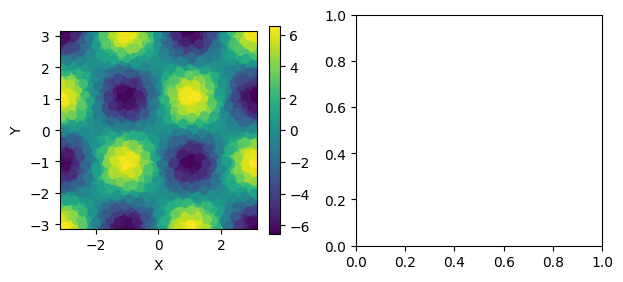

In [18]:
tasks = glob("./data/*_.npy")
for task in tasks:
    test_inference(model, task)

## Norm_input_scale 제거

* 제거하고 나니 alpha가 0.1이여도 학습이 그래도 진행되는 모습이 보인다. 하지만 Test inference를 보면 Scale에서 문제가 있는것같다.
* 이에 확인하니 latent_vector를 from_numpy로 생성하면 backpropagation이 자동으로 진행되는것은 아니라고 한다. 따라서 고정인 상태이다. 문제를 해결하고 다시 실험을 진행한다.

In [4]:
# 하이퍼 파라미터
batch_size = 100000
shuffle = True # 데이터 셔플
epochs = 1000   # 훈련 epoch
alpha= 0.1      # Total Loss = Data Loss + alpha * PDE Loss

# Data load
with open("./data/trainXYFABC.npy", 'rb') as f:
    data = np.load(f,allow_pickle=True)
f.close()

# Sample data
print(data.shape) #100000 of [x, y, f(x,y), A, B, C]

(100000, 6)


In [5]:
loader = create_dataloader(data, batch_size, shuffle)

model = LatentMLPSequential(
    in_dim=2,
    out_dim=1,
    layers=7,
    neurons=32,
    residual=True,
    in_scale= [2*np.pi,2*np.pi],
    in_center=[0, 0],
    vec_scen=2,
    vec_size=12,
)
model = model.to(device)
# loss
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10, verbose=False)
scheduler = CosineAnnealingWarmRestarts(optimizer, 500, T_mult=1, eta_min=0.0002)

# init
loss_history = []
data_loss_history = []
pde_loss_history = []
best_loss = float('inf')

#### 훈련 시작 ####
print("Train start\n")
train_model(model, loader, epochs)
print("Train end\n")

Training :   0%|          | 0/1 [00:00<?, ?it/s]

Train start



Epoch 0/1000, Total Loss: 3.1043078899383545, Data Loss: 3.0916080474853516, PDE Loss: 0.12699764966964722, LR: 0.1999980280595281
Epoch 5/1000, Total Loss: 3.834254741668701, Data Loss: 3.3506739139556885, PDE Loss: 4.835808753967285, LR: 0.19992901831679488
Epoch 10/1000, Total Loss: 3.1025731563568115, Data Loss: 3.0910592079162598, PDE Loss: 0.11513964831829071, LR: 0.1997614893854864
Epoch 15/1000, Total Loss: 3.0980639457702637, Data Loss: 3.0906875133514404, PDE Loss: 0.07376431673765182, LR: 0.1994956065964319
Epoch 20/1000, Total Loss: 3.100203275680542, Data Loss: 3.0932199954986572, PDE Loss: 0.06983340531587601, LR: 0.1991316323438437
Epoch 25/1000, Total Loss: 3.2443342208862305, Data Loss: 3.121145248413086, PDE Loss: 1.231890082359314, LR: 0.19866992582636603
Epoch 30/1000, Total Loss: 3.140291452407837, Data Loss: 3.0999093055725098, PDE Loss: 0.40382254123687744, LR: 0.19811094269258908
Epoch 35/1000, Total Loss: 3.1868703365325928, Data Loss: 3.1003737449645996, PDE L

KeyboardInterrupt: 

Test MSE Loss :  3.5527879289174105


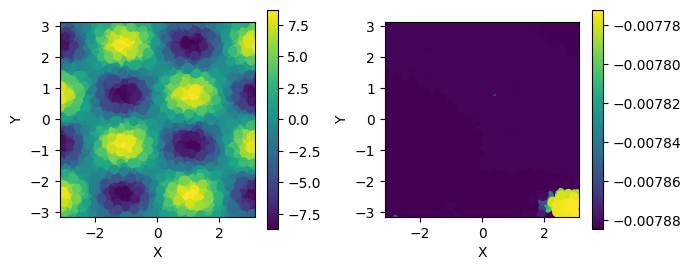

Test MSE Loss :  0.4027985309634809


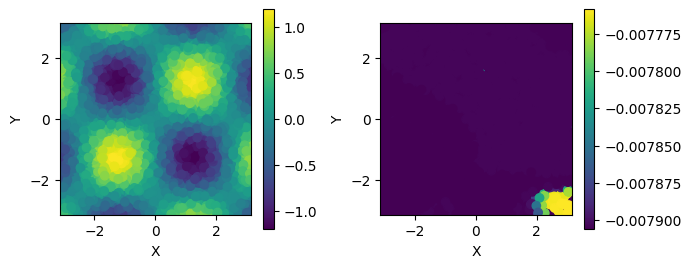

Test MSE Loss :  1.5804963324774752


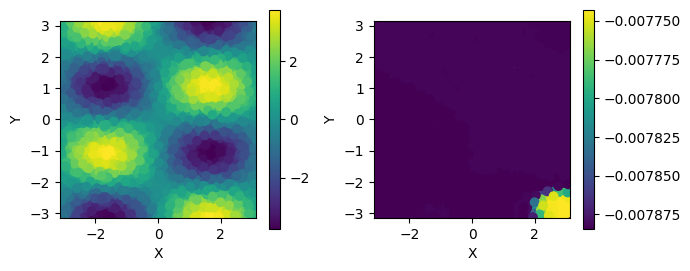

Test MSE Loss :  4.339379043240544


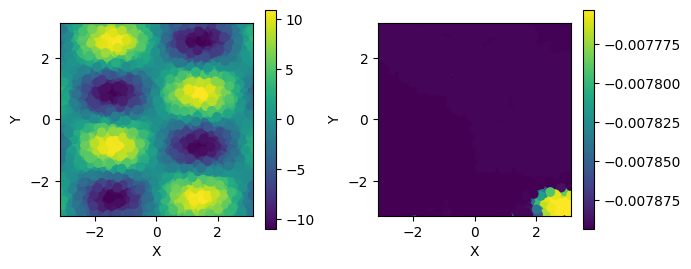

Test MSE Loss :  0.693982258154489


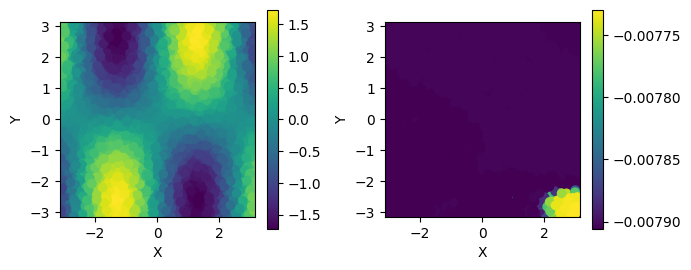

Test MSE Loss :  2.651280386964791


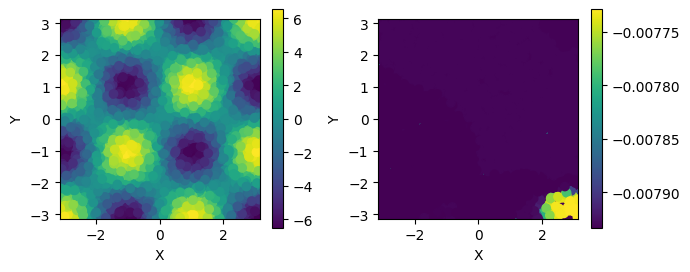

Test MSE Loss :  4.506253737920412


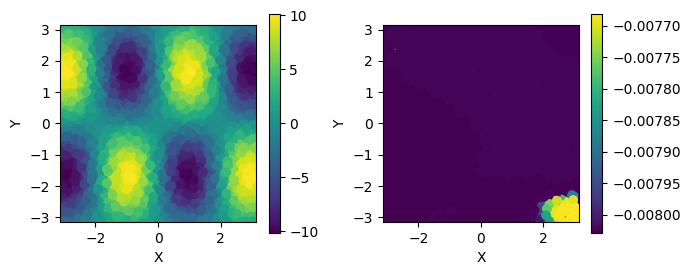

Test MSE Loss :  2.1041256608686907


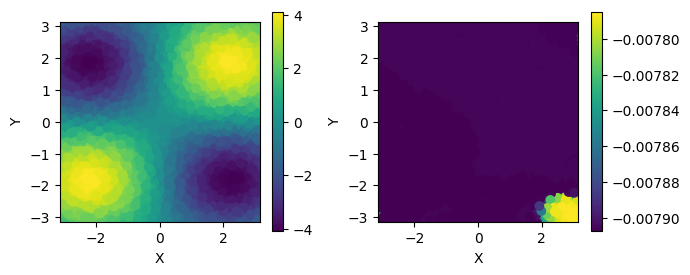

Test MSE Loss :  2.7105086756875028


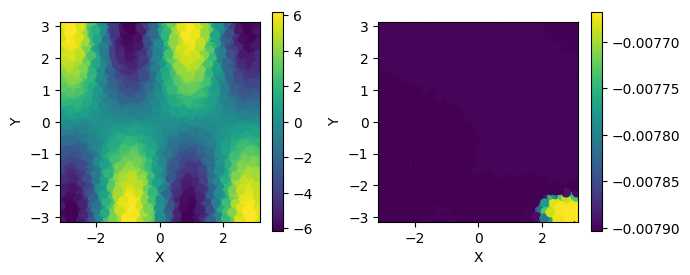

Test MSE Loss :  2.8489489962027896


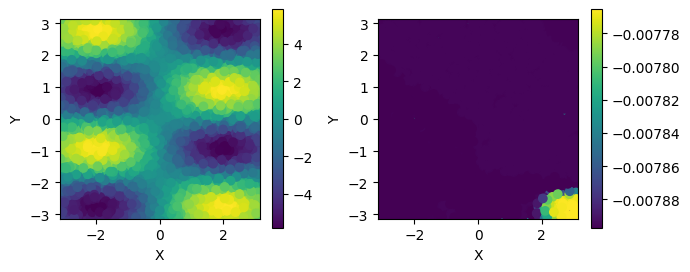

Test MSE Loss :  3.5595952664864243


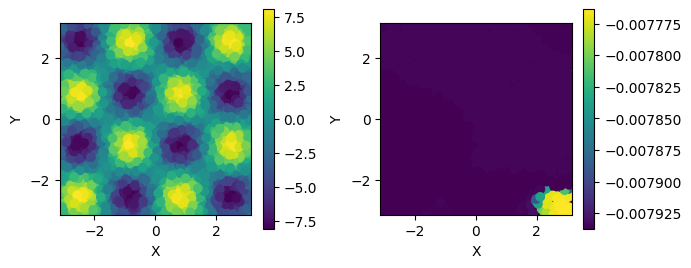

Test MSE Loss :  3.4735559742064055


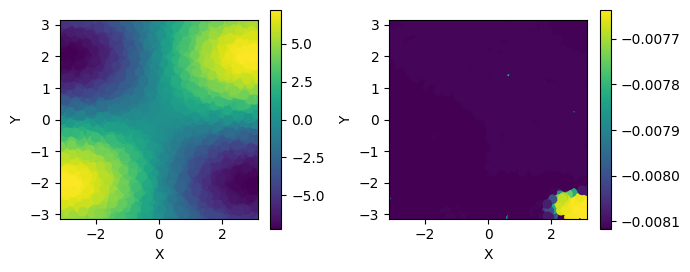

Test MSE Loss :  1.0555994502485178


KeyboardInterrupt: 

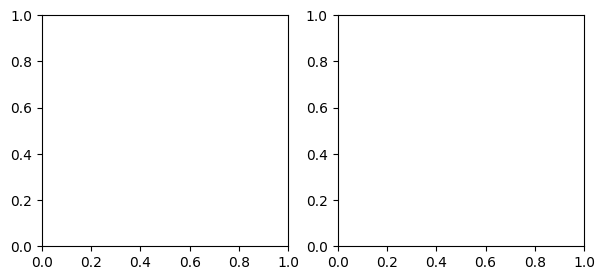

In [6]:
tasks = glob("./data/*_.npy")
for task in tasks:
    test_inference(model, task)

## Latent Vector의 Backpropagation 문제 해결

In [4]:
# 하이퍼 파라미터
batch_size = 100000
shuffle = True # 데이터 셔플
epochs = 1000   # 훈련 epoch
alpha= 0.1      # Total Loss = Data Loss + alpha * PDE Loss

# Data load
with open("./data/trainXYFABC.npy", 'rb') as f:
    data = np.load(f,allow_pickle=True)
f.close()

# Sample data
print(data.shape) #100000 of [x, y, f(x,y), A, B, C]

(100000, 6)


In [5]:
loader = create_dataloader(data, batch_size, shuffle)

model = LatentMLPSequential(
    in_dim=2,
    out_dim=1,
    layers=7,
    neurons=32,
    residual=True,
    vec_scen=2,
    vec_size=12,
)
model = model.to(device)
# loss
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10, verbose=False)
scheduler = CosineAnnealingWarmRestarts(optimizer, 500, T_mult=1, eta_min=0.0002)

# init
loss_history = []
data_loss_history = []
pde_loss_history = []
best_loss = float('inf')

#### 훈련 시작 ####
print("Train start\n")
train_model(model, loader, epochs)
print("Train end\n")

Training :   0%|          | 0/1 [00:00<?, ?it/s]

Train start



Epoch 0/1000, Total Loss: 3.1100881099700928, Data Loss: 3.0936710834503174, PDE Loss: 0.16417036950588226, LR: 0.1999980280595281
Epoch 5/1000, Total Loss: 3.97310471534729, Data Loss: 3.4012038707733154, PDE Loss: 5.719007968902588, LR: 0.19992901831679488
Epoch 10/1000, Total Loss: 3.464005947113037, Data Loss: 3.187584400177002, PDE Loss: 2.764214277267456, LR: 0.1997614893854864
Epoch 15/1000, Total Loss: 3.093846559524536, Data Loss: 3.091921806335449, PDE Loss: 0.019246794283390045, LR: 0.1994956065964319
Epoch 20/1000, Total Loss: 3.0912530422210693, Data Loss: 3.0907130241394043, PDE Loss: 0.005401321686804295, LR: 0.1991316323438437
Epoch 25/1000, Total Loss: 3.0916099548339844, Data Loss: 3.091301202774048, PDE Loss: 0.0030864074360579252, LR: 0.19866992582636603
Epoch 30/1000, Total Loss: 3.095735788345337, Data Loss: 3.092341423034668, PDE Loss: 0.033943403512239456, LR: 0.19811094269258908
Epoch 35/1000, Total Loss: 3.129324436187744, Data Loss: 3.0980937480926514, PDE Lo

KeyboardInterrupt: 

Test MSE Loss :  3.5399458135038366


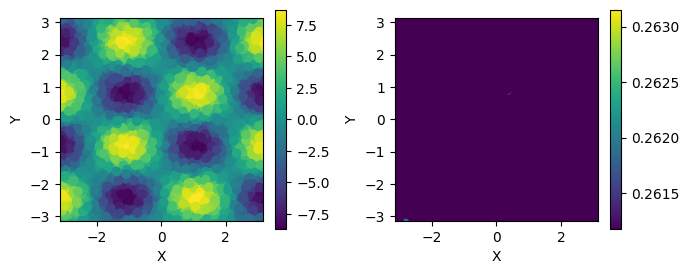

Test MSE Loss :  0.4040276445209529


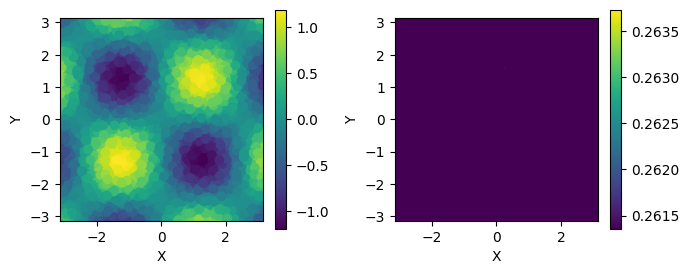

Test MSE Loss :  1.5616332227844387


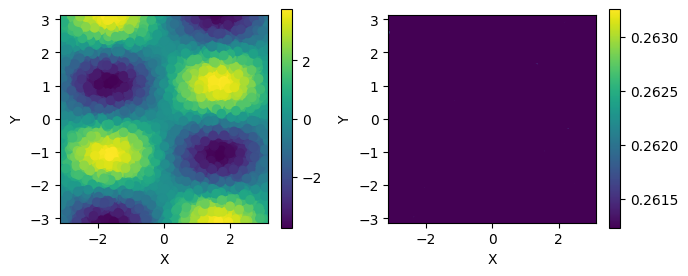

Test MSE Loss :  4.328735415295275


KeyboardInterrupt: 

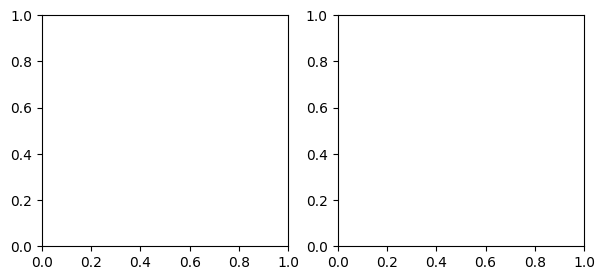

In [6]:
tasks = glob("./data/*_.npy")
for task in tasks:
    test_inference(model, task)